# 2. Clustering particional

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
import plotly.express as px




## 2.1 Preprocesamiento de datos

- Eliminación de outliers -> sesgan centroids
- However, tal vez no son outliers sino concentraciones menores de accidentes en otros barrios?

In [3]:
# primero importamos los csv scaled_df, normalized_df y df_grouped

scaled_df = pd.read_csv('scaled_df.csv')
normalized_df = pd.read_csv('normalized_df.csv')
df_grouped = pd.read_csv('df_grouped.csv')

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis

# Función para calcular y filtrar outliers usando Mahalanobis
def filter_outliers_mahalanobis(df, columns, percentile=97.5):
    data = df[columns].values

    # Verificar que no haya valores NaN
    data = data[~np.isnan(data).any(axis=1)]

    # Calcular la media y la matriz de covarianza inversa
    mean = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calcular las distancias de Mahalanobis
    distances = [mahalanobis(row, mean, inv_cov_matrix) for row in data]

    # Definir el umbral según el percentil deseado
    threshold = np.percentile(distances, percentile)

    # Añadir las distancias al DataFrame
    df['mahalanobis_distance'] = np.nan  # Inicializar columna
    df.loc[~np.isnan(df[columns]).any(axis=1), 'mahalanobis_distance'] = distances

    # Filtrar por el umbral
    return df[df['mahalanobis_distance'] <= threshold]

# Uso de la función
columns_to_check = ['coordenada_x_utm', 'coordenada_y_utm']  # Sustituir con tus columnas
df_filtered = filter_outliers_mahalanobis(normalized_df, columns_to_check, percentile=97.5)


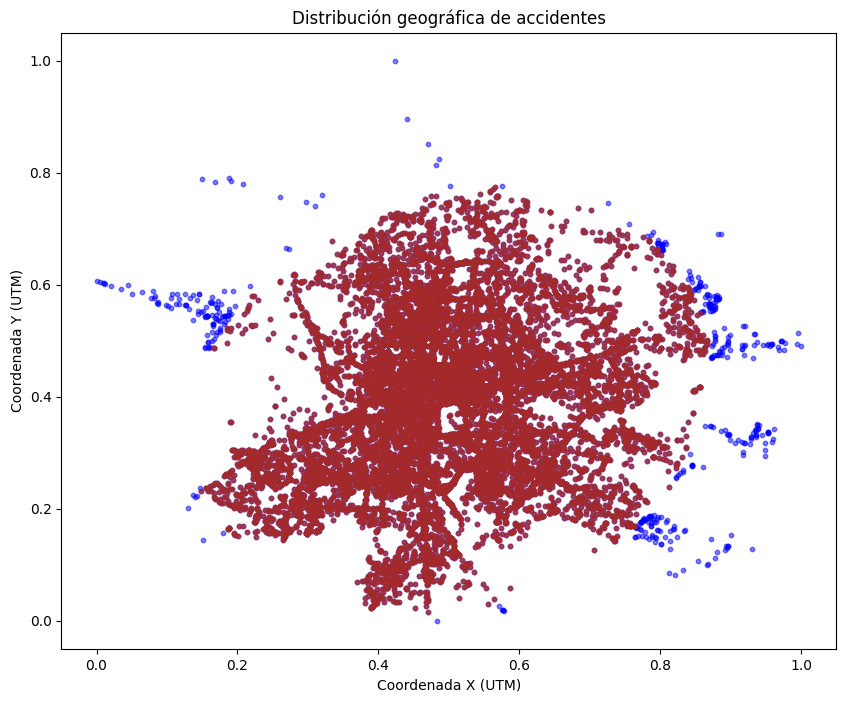

In [5]:
# Scatterplot
plt.figure(figsize=(10, 8))
plt.scatter(normalized_df['coordenada_x_utm'], normalized_df['coordenada_y_utm'], alpha=0.5, s=10, color='blue')
plt.scatter(df_filtered['coordenada_x_utm'], df_filtered['coordenada_y_utm'], alpha=0.7, s=10, color='brown')
plt.title('Distribución geográfica de accidentes')
plt.xlabel('Coordenada X (UTM)')
plt.ylabel('Coordenada Y (UTM)')
plt.show()


El "preprocesamiento necesario para poder aplicar algoritmos de clustering particional" es básicamente la normalización de los datos ya que k-means se basa en distancias. En este caso, ya los hemos normalizado con MinMax scaler en el notebook anterior.

## 2.2 Número óptimo de clusters

#### Elbow method

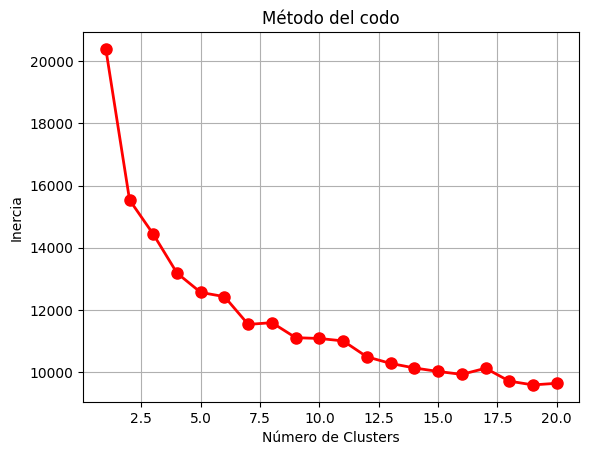

In [25]:
def plot_results(inertials):
   
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del codo')
    plt.show()


def select_clusters_from_dataframe(df, loops, max_iterations, init_cluster, tolerance):
    
    # Convertir el dataframe a un array numpy
    points = df

    inertia_clusters = []

    for i in range(1, loops + 1):
        # Crear objeto KMeans
        kmeans = KMeans(
            n_clusters=i,
            max_iter=max_iterations,
            init=init_cluster,
            tol=tolerance
        )

        # Ajustar el modelo
        kmeans.fit(points)

        # Guardar el número de clusters y la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    # Graficar los resultados
    plot_results(inertia_clusters)


# Parámetros constantes
LOOPS = 20
MAX_ITERATIONS = 10
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001

select_clusters_from_dataframe(
    df=df_filtered,  # Sustituye con tu dataframe
    loops=LOOPS,
    max_iterations=MAX_ITERATIONS,
    init_cluster=INITIALIZE_CLUSTERS,
    tolerance=CONVERGENCE_TOLERANCE
)


#### Gap

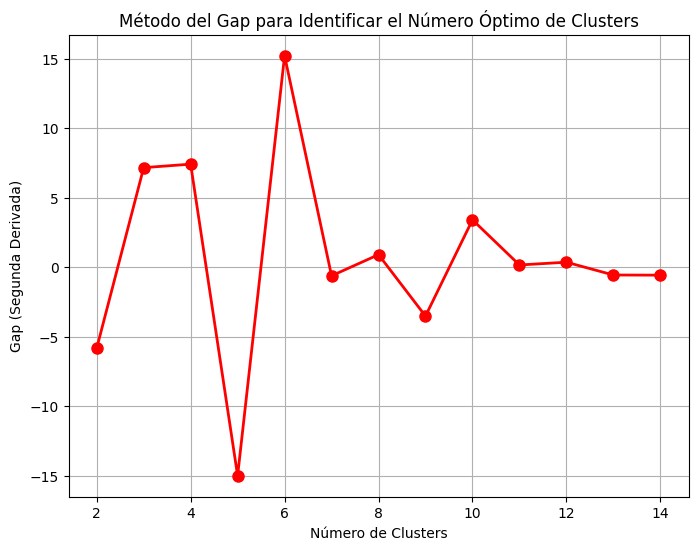

In [24]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

def plot_gap_from_dataframe(data):
    
    # Asegurarse de que los datos sean numéricos (sin columnas no válidas)
    points = data.select_dtypes(include=[np.number]).values

    # Calcular distancias jerárquicas entre puntos usando el método Ward
    Z = linkage(points, metric='euclidean', method='ward')

    # Obtener las últimas 10 distancias entre puntos o grupos
    last = Z[-15:, 2]
    num_clusters = np.arange(1, len(last) + 1)

    # Calcular el gap (segunda derivada de las distancias)
    gap = np.diff(last, n=2)  # Segunda diferencia (derivada discreta)

    # Visualizar el resultado
    plt.figure(figsize=(8, 6))
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.title('Método del Gap para Identificar el Número Óptimo de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Gap (Segunda Derivada)')
    plt.grid(True)
    plt.show()


# Llamar a la función
plot_gap_from_dataframe(df_filtered)


## 2.3 Calidad de clusters según k

## 2.4 Obtención de información de clusters -> mal

In [11]:
def pca_2D_visualization(data, title="Distribución en las primeras 2 componentes"):
    
    # Aplicar PCA
    pca_2D = PCA(n_components=2)
    X_2D = pca_2D.fit_transform(data)
    
    # Visualización en 2D
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1])
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(title)
    plt.show()


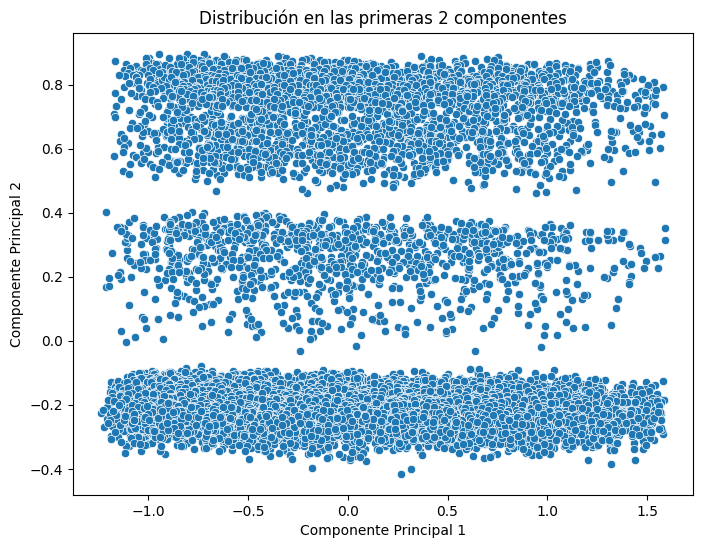

In [16]:
pca_2D_visualization(df_filtered, title="Distribución en las primeras 2 componentes")

Es raro porque con normalized y filtered no es capaz de agrupar los datos pero con scaled y grouped, lo hace bastante bien a primera vista.

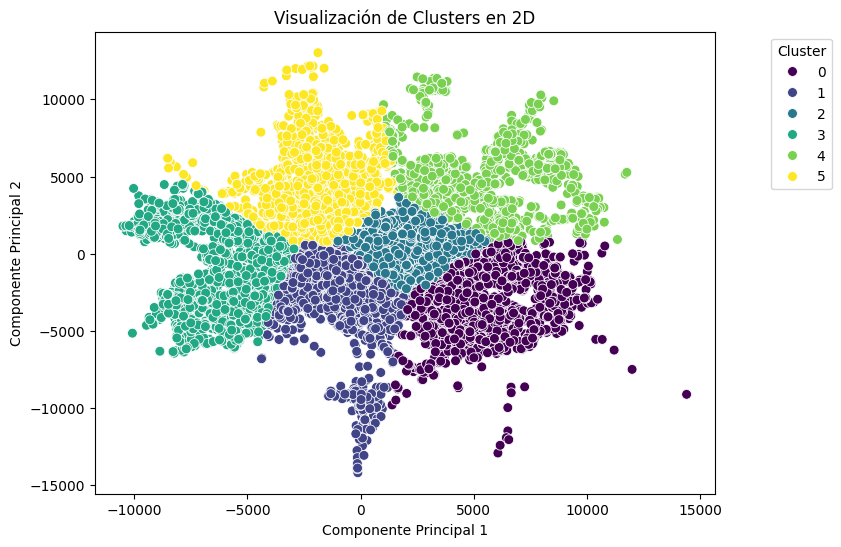

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros de K-Means
k = 6  # Número de clusters (puedes ajustarlo según sea necesario)
random_state = 42  # Para reproducibilidad

# Inicialización y ajuste del modelo K-Means
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(scaled_df)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Aplicar PCA para reducir a 2 dimensiones
pca_2D = PCA(n_components=2)
X_2D = pca_2D.fit_transform(df_grouped)

# Visualización en 2D con colores según los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_2D[:, 0], 
    y=X_2D[:, 1], 
    hue=labels, 
    palette='viridis', 
    s=50
)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters en 2D')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Número de clusters que deseas (k)
k = 3  # Puedes cambiar este valor según lo que necesites

# Inicialización del modelo KMeans
kmeans = KMeans(n_clusters=k, random_state=42)

# Ajustar el modelo KMeans al DataFrame normalizado
kmeans.fit(df_filtered)

# Obtener las etiquetas (clusters asignados)
labels = kmeans.labels_

# Crear una copia explícita del DataFrame para evitar el SettingWithCopyWarning
df_filtered_copy = df_filtered.copy()

# Añadir las etiquetas de los clusters al DataFrame copiado
df_filtered_copy['Cluster'] = labels


In [52]:
# Crear un DataFrame con las etiquetas de los clusters
df_filtered_copy['Cluster'] = labels

# Resumen de las características por cluster
cluster_summary = df_filtered_copy.groupby('Cluster').mean()
cluster_summary


,cod_distrito,tipo_accidente,estado_meteorológico,coordenada_x_utm,coordenada_y_utm,fecha_month,fecha_day,hora_hour,hora_minute,sexo_Mujer,...,rango_edad_25-34,rango_edad_35-44,rango_edad_45-59,rango_edad_60+,tipo_persona_Conductor,tipo_persona_Pasajero,tipo_persona_Peatón,positiva_alcohol,cod_lesividad,mahalanobis_distance
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.650659,0.391841,0.216775,0.516522,0.391021,0.494056,0.494691,0.599547,0.445149,0.080535,...,0.057277,0.053384,0.103157,0.037876,0.100067,0.031606,0.012955,0.075497,0.144516,2.011596
1,0.149025,0.370053,0.209878,0.487213,0.394461,0.500897,0.487054,0.584455,0.448093,0.072669,...,0.070757,0.058277,0.111426,0.037798,0.098739,0.030206,0.012709,0.043270,0.161088,0.564306
2,0.515558,0.387185,0.207283,0.498014,0.384683,0.503904,0.480623,0.599427,0.439131,0.077320,...,0.067549,0.057090,0.101555,0.038437,0.102536,0.034408,0.013565,0.082799,0.150082,1.194383


In [46]:
# Calcular la desviación estándar de cada característica entre clusters
feature_std_by_cluster = df_filtered.groupby('Cluster').std()
feature_std_by_cluster


,cod_distrito,tipo_accidente,estado_meteorológico,coordenada_x_utm,coordenada_y_utm,fecha_month,fecha_day,hora_hour,hora_minute,sexo_Mujer,...,rango_edad_25-34,rango_edad_35-44,rango_edad_45-59,rango_edad_60+,tipo_persona_Conductor,tipo_persona_Pasajero,tipo_persona_Peatón,positiva_alcohol,cod_lesividad,mahalanobis_distance
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.233018,0.255140,0.378653,0.194052,0.211408,0.321474,0.293595,0.243735,0.293720,0.096167,...,0.092862,0.078637,0.124357,0.077705,0.041046,0.068246,0.048109,0.264221,0.179616,0.283302
1,0.146911,0.256479,0.372009,0.053445,0.063850,0.321562,0.290779,0.255815,0.295476,0.093776,...,0.101989,0.083425,0.128271,0.078381,0.033502,0.069708,0.047772,0.203482,0.185408,0.218668
2,0.187266,0.251905,0.371155,0.110529,0.130253,0.320835,0.293428,0.251675,0.295881,0.098381,...,0.099494,0.081945,0.123910,0.079504,0.039903,0.074246,0.051235,0.275599,0.180574,0.233074


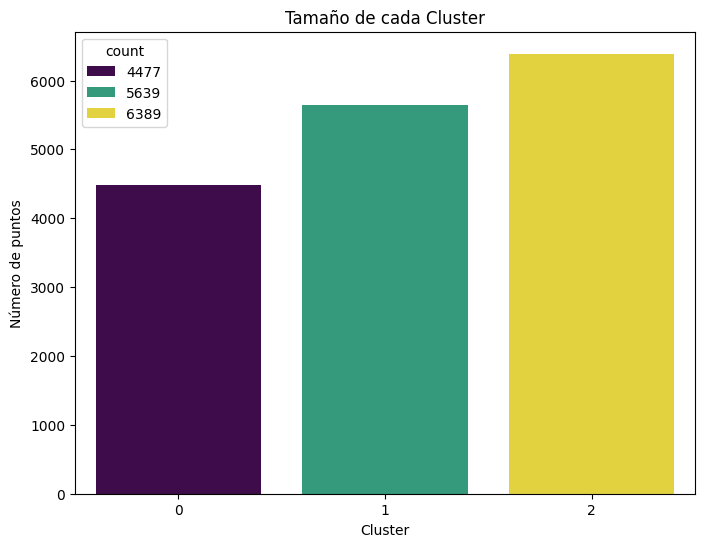

In [68]:
plt.figure(figsize=(8, 6))
cluster_sizes = df_filtered_copy['Cluster'].value_counts()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', hue=cluster_sizes)
plt.title('Tamaño de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')
plt.show()

Clusters de tamaños desbalanceados podría ser un signo de agrupaciones desequilibradas o incluso de ruido en los datos. En este caso estan relativamente balanceados.

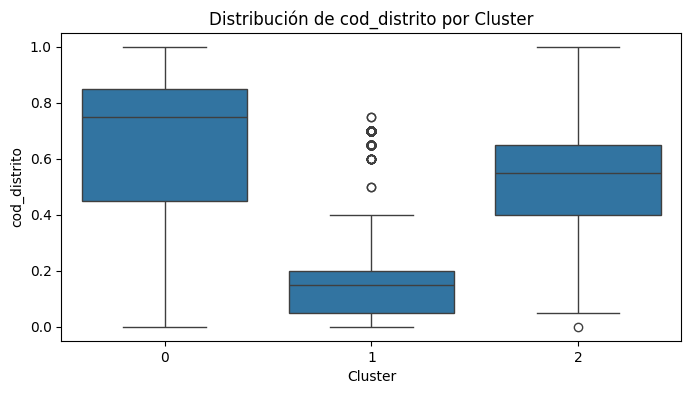

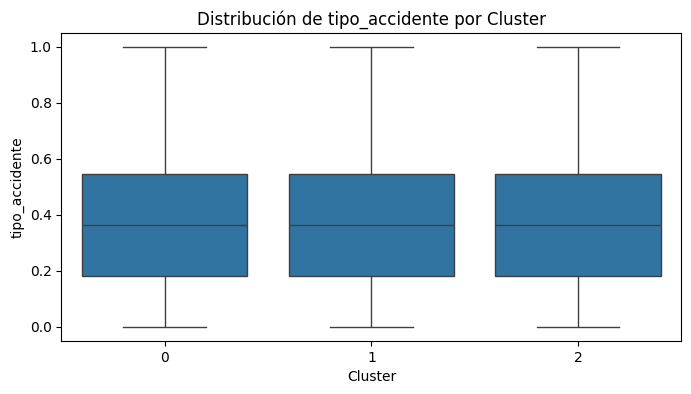

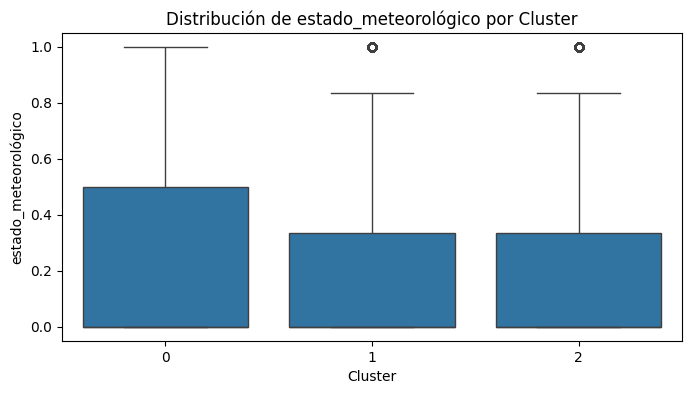

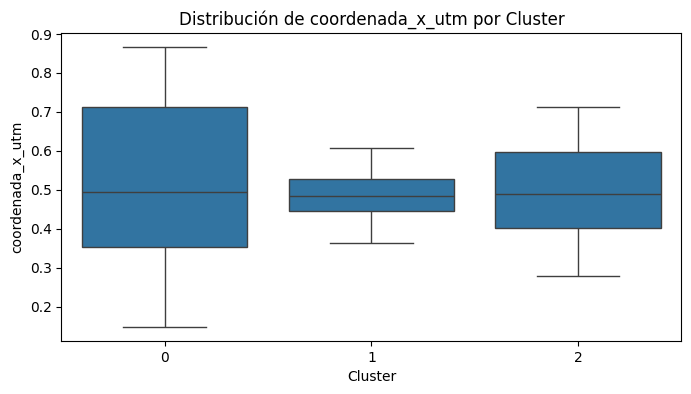

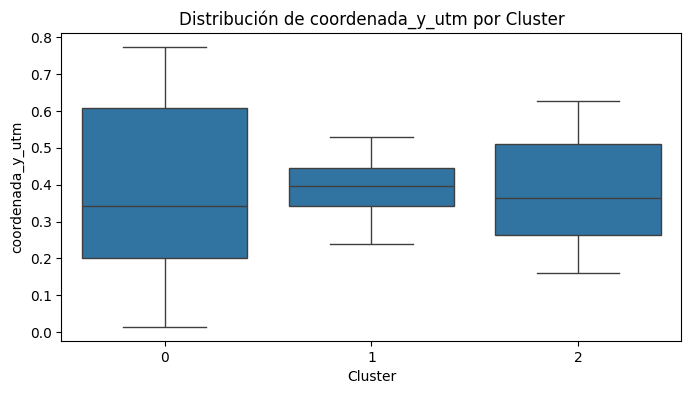

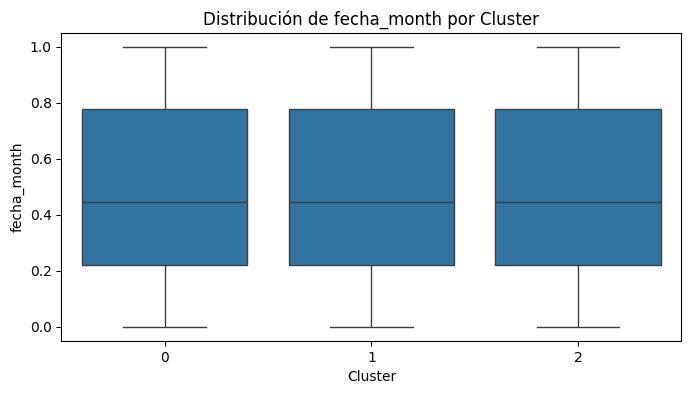

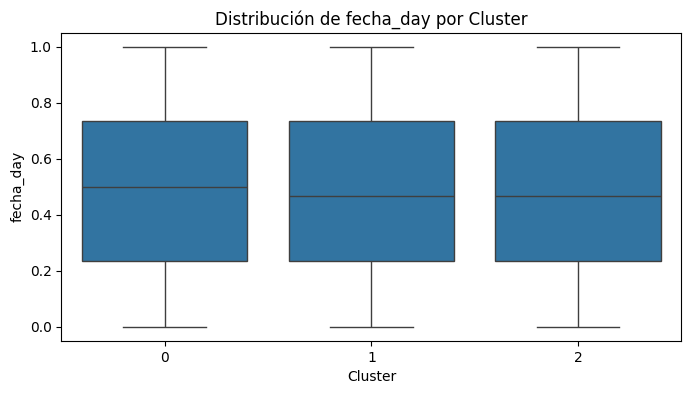

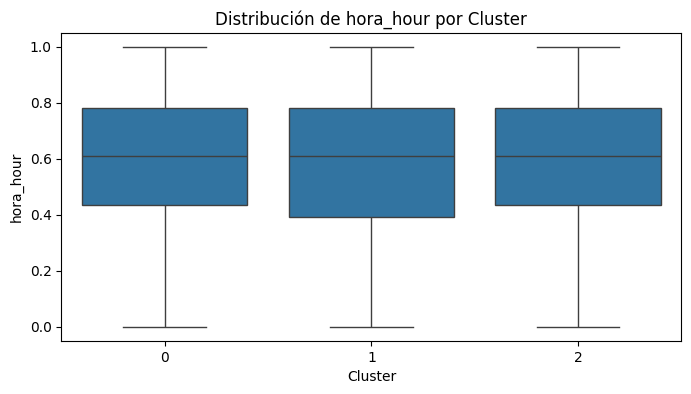

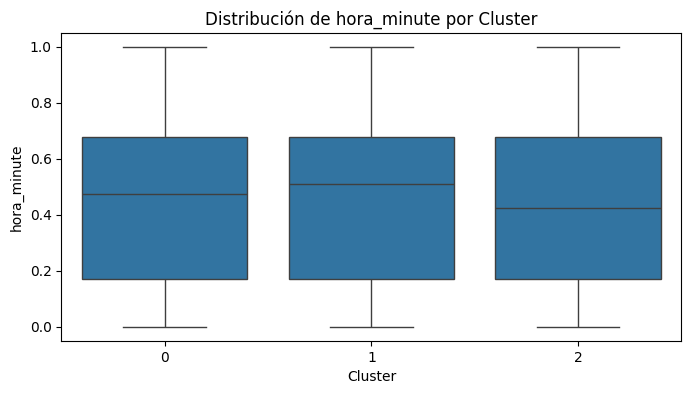

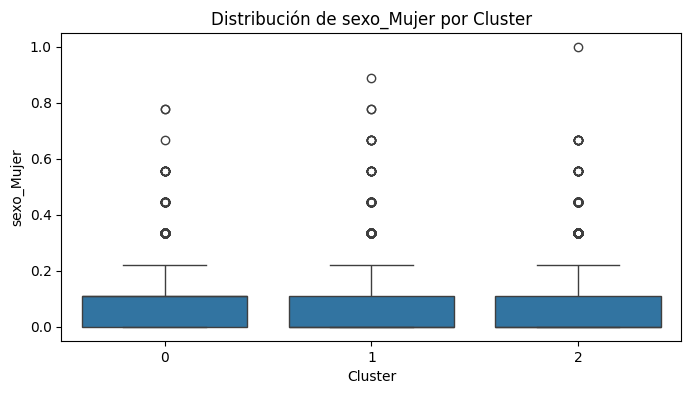

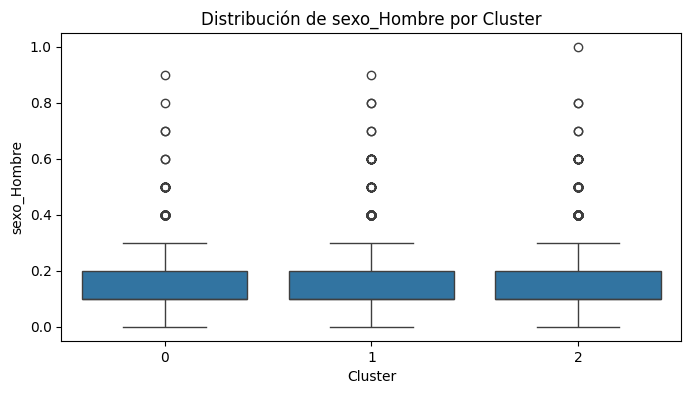

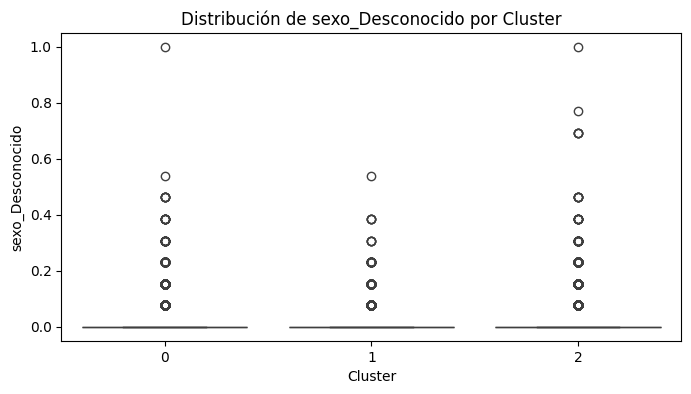

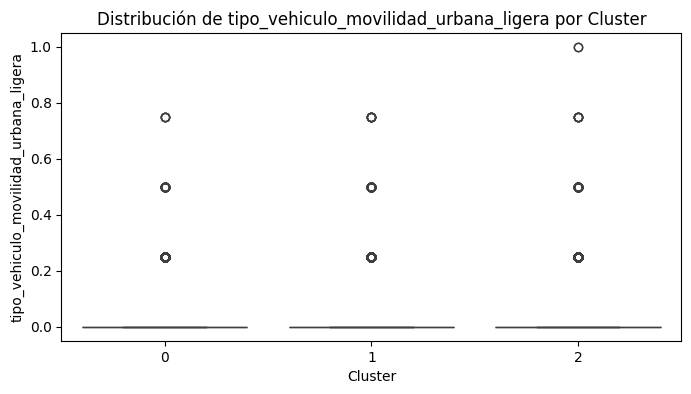

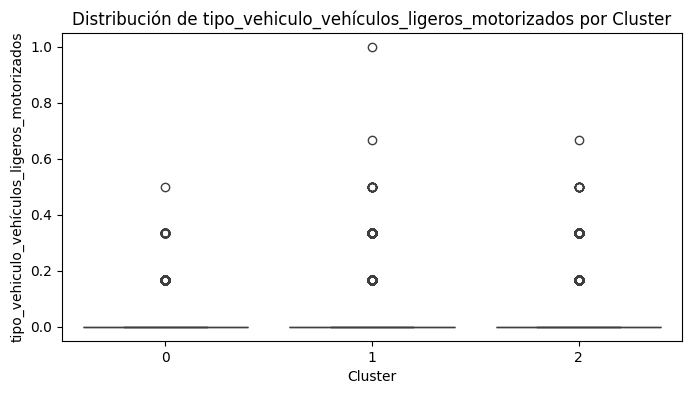

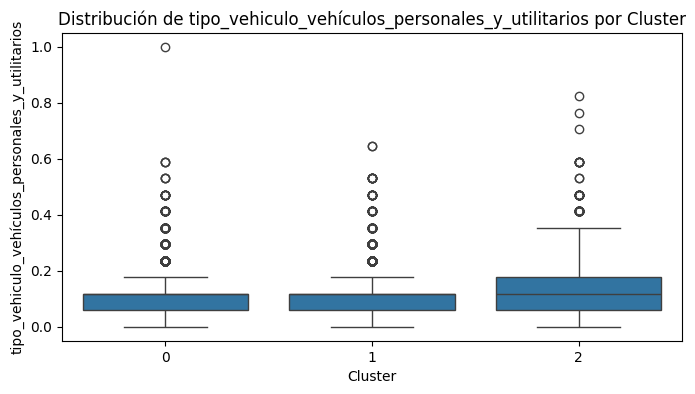

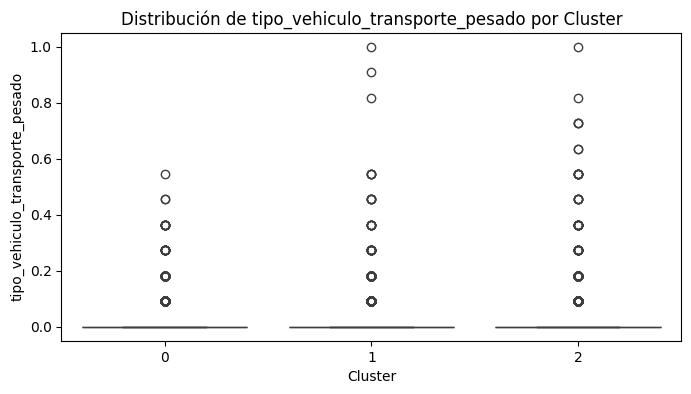

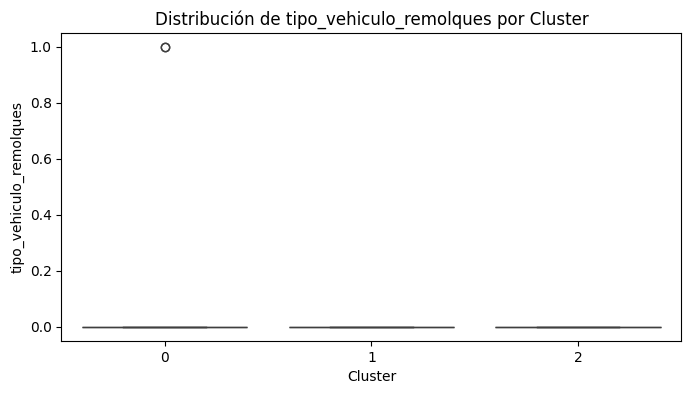

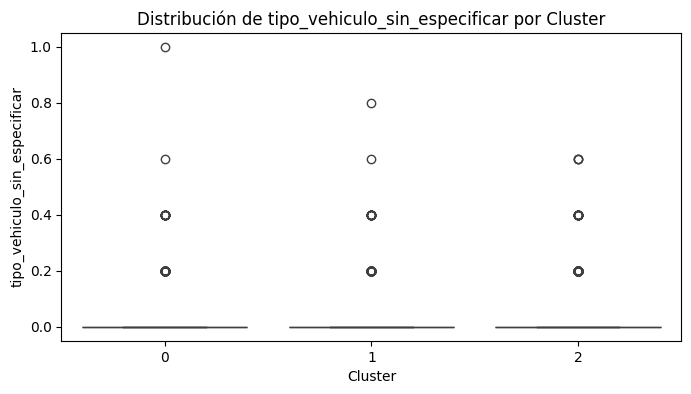

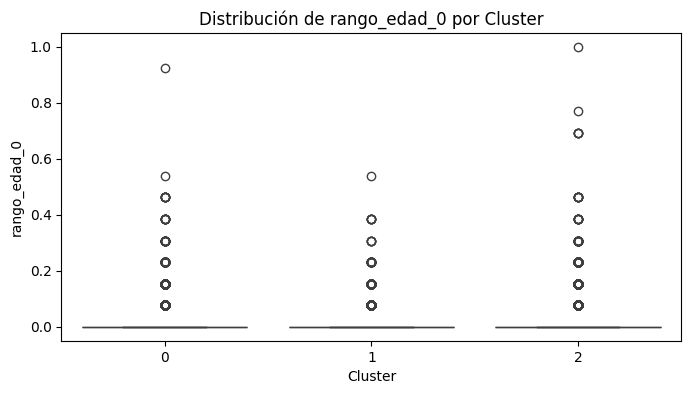

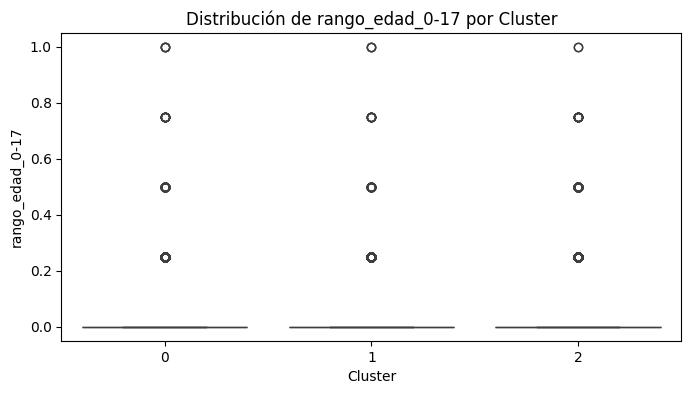

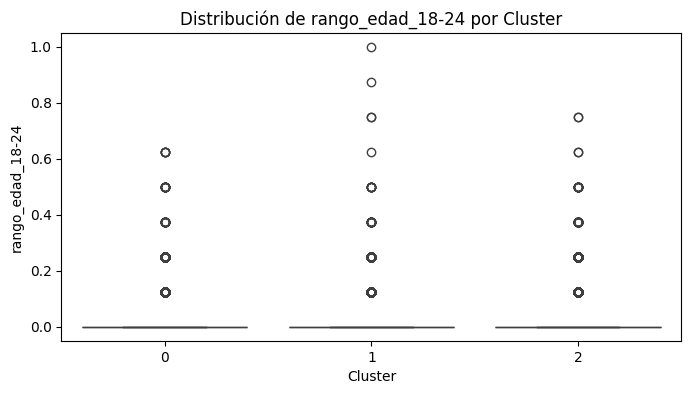

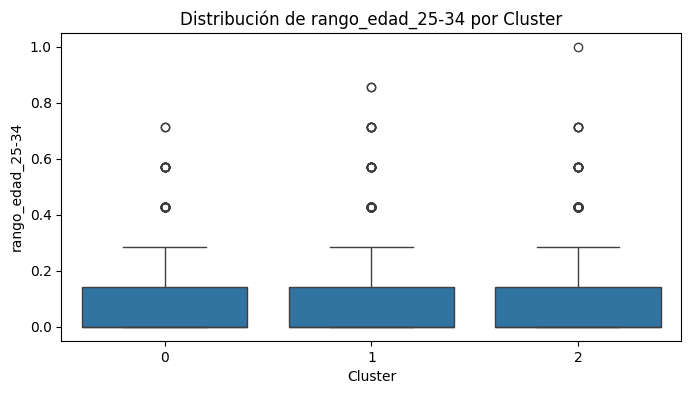

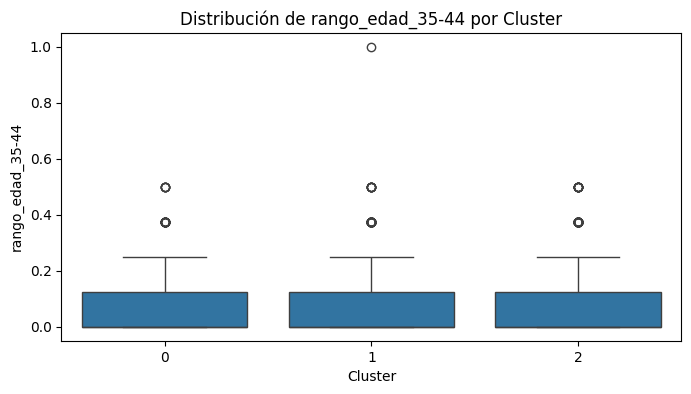

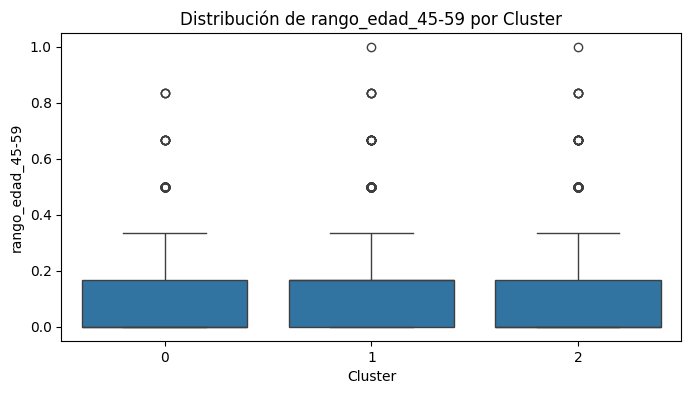

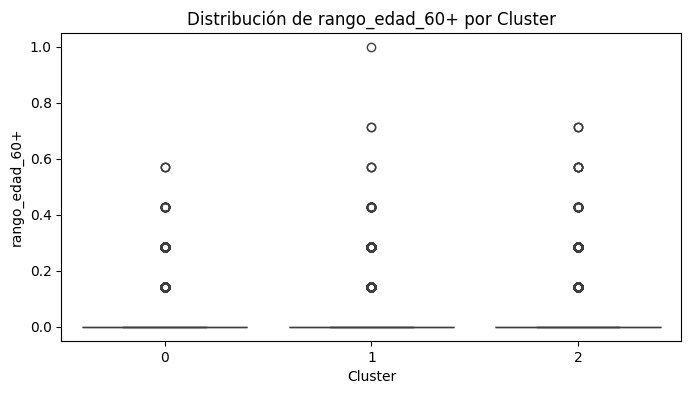

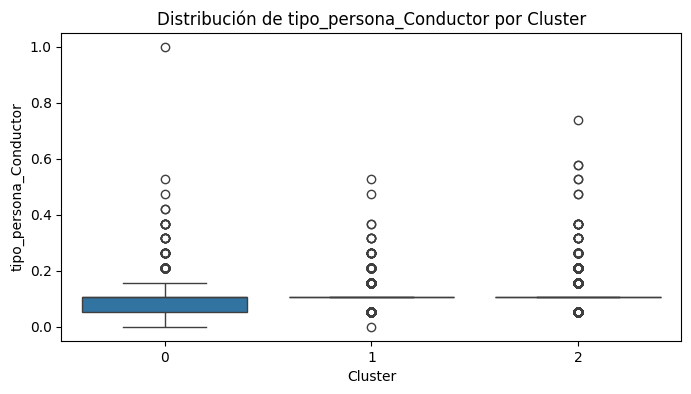

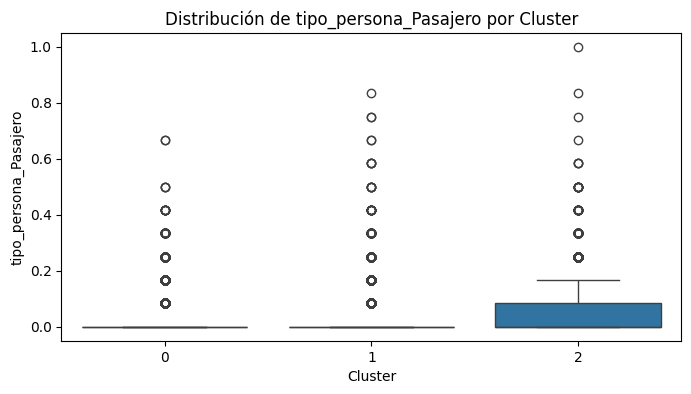

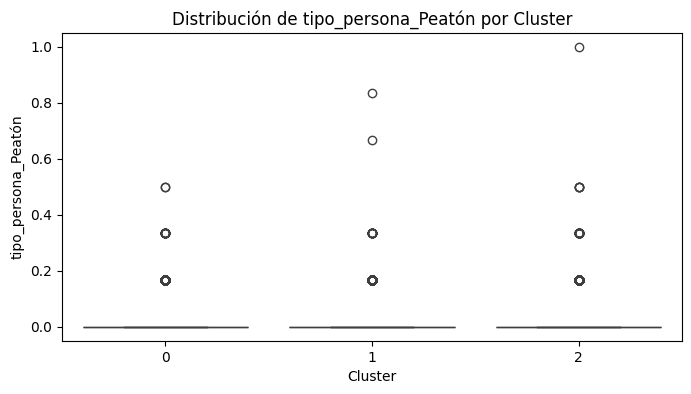

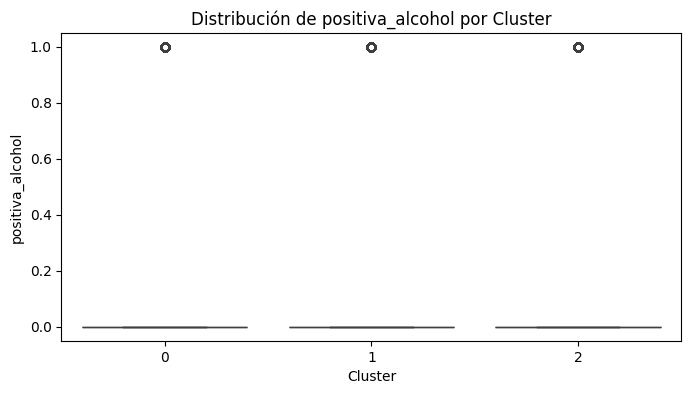

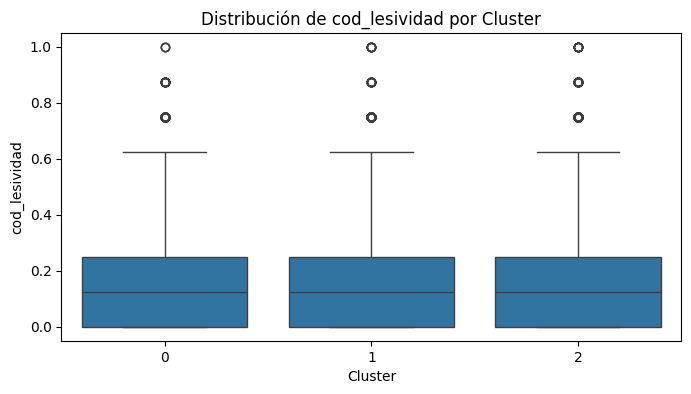

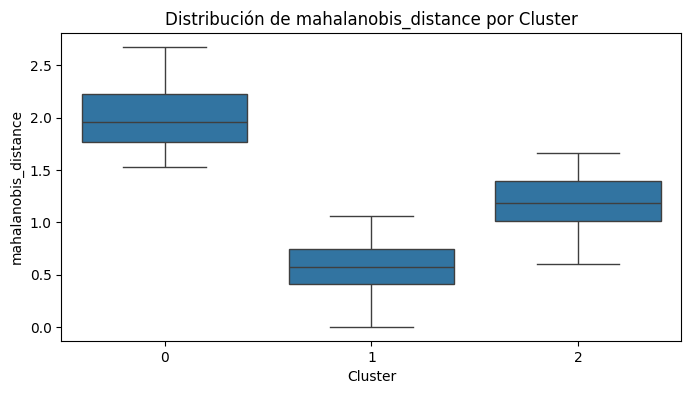

In [51]:
import seaborn as sns

# Visualizar la distribución de una variable por cluster
for column in df_filtered.columns[:-1]:  # Excluye la columna 'Cluster'
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster', y=column, data=df_filtered)
    plt.title(f'Distribución de {column} por Cluster')
    plt.show()


**Información:**
- Linea mid-box: mediana ->  Si una característica tiene valores claramente diferentes entre clusters, significa que es una variable importante para diferenciarlos.
- Rango intercuartílico: Indica la dispersión de los datos dentro del cluster. Un rango estrecho sugiere poca variabilidad en esa característica.
- Outliers: Puntos fuera del rango típico. Pueden indicar valores atípicos interesantes o ruido.

In [57]:
# Asegúrate de que las columnas coincidan con las usadas en el entrenamiento
feature_columns = df_filtered_copy.columns[:-1]  # Excluye 'Cluster'
if len(feature_columns) != kmeans.cluster_centers_.shape[1]:
    feature_columns = df_filtered_copy.columns[:kmeans.cluster_centers_.shape[1]]  # Ajusta el rango

# Crear un DataFrame para los centroides
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=feature_columns)

print("Centroides de los clusters:")
centroids_df


Centroides de los clusters:


,cod_distrito,tipo_accidente,estado_meteorológico,coordenada_x_utm,coordenada_y_utm,fecha_month,fecha_day,hora_hour,hora_minute,sexo_Mujer,...,rango_edad_35-44,rango_edad_45-59,rango_edad_60+,tipo_persona_Conductor,tipo_persona_Pasajero,tipo_persona_Peatón,positiva_alcohol,cod_lesividad,mahalanobis_distance,Cluster
0,0.650659,0.391841,0.216775,0.516522,0.391021,0.494056,0.494691,0.599547,0.445149,0.080535,...,0.053384,0.103157,0.037876,0.100067,0.031606,0.012955,0.075497,0.144516,2.011596,3.108624e-15
1,0.149025,0.370053,0.209878,0.487213,0.394461,0.500897,0.487054,0.584455,0.448093,0.072669,...,0.058277,0.111426,0.037798,0.098739,0.030206,0.012709,0.043270,0.161088,0.564306,1.000000e+00
2,0.515558,0.387185,0.207283,0.498014,0.384683,0.503904,0.480623,0.599427,0.439131,0.077320,...,0.057090,0.101555,0.038437,0.102536,0.034408,0.013565,0.082799,0.150082,1.194383,2.000000e+00


Si los valores de una característica son muy diferentes entre clusters, es una señal de que esa característica ayuda a diferenciarlos -> nos sirve para etiquetar los clusters

In [55]:
# Componentes principales para identificar la importancia de las variables
pca = PCA(n_components=2)
pca.fit(df_filtered.drop('Cluster', axis=1))  # Excluye la columna 'Cluster'

# Cargar las contribuciones de cada característica a los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=df_filtered.columns[:-1], index=['PC1', 'PC2'])
print("Contribuciones de las características a los componentes principales:")
print(pca_components.T)  # Transponer para facilitar la lectura


Contribuciones de las características a los componentes principales:
                                                       PC1       PC2
cod_distrito                                      0.314300 -0.029329
tipo_accidente                                    0.014686  0.048671
estado_meteorológico                              0.011422  0.981813
coordenada_x_utm                                  0.023523 -0.007994
coordenada_y_utm                                 -0.008102  0.006469
fecha_month                                      -0.006132 -0.121373
fecha_day                                         0.004555 -0.008587
hora_hour                                         0.009929  0.018417
hora_minute                                      -0.001727 -0.024617
sexo_Mujer                                        0.004659 -0.010459
sexo_Hombre                                      -0.009461 -0.015586
sexo_Desconocido                                  0.006475  0.010009
tipo_vehiculo_movilidad_urbana_lig